# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from matplotlib import pyplot
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

<h1><center>-------------------------------------- Preprocessing --------------------------------------</center></h1>

In [2]:
# read raw files
coffee_data = pd.read_excel('Dataset/coffee.xlsx')
fuel_data = pd.read_excel('Dataset/fuel.xlsx')
weather_data = pd.read_excel('Dataset/weather.xlsx')

### Filter Coffee data

In [3]:
coffee_data['Ngày'] = pd.to_datetime(coffee_data['Ngày'])
# fill up missing dates
coffee_data = coffee_data.set_index('Ngày').resample('D').ffill().reset_index()
coffee_data

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
864,2023-05-15,55566.5
865,2023-05-16,56066.5
866,2023-05-17,56666.5
867,2023-05-18,57000.0


### Filter Diesel data

In [4]:
fuel_data["Ngày"] = pd.to_datetime(fuel_data["Ngày"], format="%d.%m.%Y")

# fill up missing dates
fuel_data = fuel_data.set_index('Ngày').resample('D').ffill().reset_index()

# reverse the order
# fuel_data = fuel_data[::-1]

fuel_data.head()

,Ngày,Giá Diesel 1 lít
0,2019-01-01,14900.0
1,2019-01-02,14900.0
2,2019-01-03,14900.0
3,2019-01-04,14900.0
4,2019-01-05,14900.0


### Filter Weather Data

In [5]:
weather_data["time"] = pd.to_datetime(weather_data["time"], format="%d.%m.%Y")
weather_data.head()

,time,temperature_mean (°C),precipitation_sum (mm)
0,2018-01-01,21.183332,0.0
1,2018-01-02,21.558332,0.0
2,2018-01-03,22.604166,0.0
3,2018-01-04,23.062494,3.6
4,2018-01-05,23.937500,0.3


<h1><center>-------------------------------------- Calculate Weather --------------------------------------</center></h1>

In [6]:
# 2020
year2020 = (weather_data['time'] >= '2020-1-1') & (weather_data['time'] <= '2020-12-31')
df2 = weather_data.loc[year2020]
# total precipitation
prec2020 = df2["precipitation_sum (mm)"].sum()
# total days
temp2020 = df2[(df2['temperature_mean (°C)'] >= 24) & (df2['temperature_mean (°C)'] <= 30)]

# 2021
year2021 = (weather_data['time'] >= '2021-1-1') & (weather_data['time'] <= '2021-12-31')
df2 = weather_data.loc[year2021]
# total precipitation
prec2021 = df2["precipitation_sum (mm)"].sum()
# total days
temp2021 = df2[(df2['temperature_mean (°C)'] >= 24) & (df2['temperature_mean (°C)'] <= 30)]

#2022
year2022 = (weather_data['time'] >= '2022-1-1') & (weather_data['time'] <= '2022-12-31')
df2 = weather_data.loc[year2022]
# total precipitation
prec2022 = df2["precipitation_sum (mm)"].sum()
# total days
temp2022 = df2[(df2['temperature_mean (°C)'] >= 24) & (df2['temperature_mean (°C)'] <= 30)]

<h1><center>-------------------------------------- Merge Data --------------------------------------</center></h1>

In [7]:
# # Merge the dataframes with an outer join
# merged_df = pd.merge(coffee_data, fuel_data, left_on='Ngày', right_on='Ngày', how="outer")

# # Fill missing dates from both datasets with each other
# merged_df.fillna(method='bfill', inplace=True)

In [8]:
# 3 months before first coffee price
mask = (fuel_data['Ngày'] >= '2020-10-1') 
diesel3 = fuel_data.loc[mask]
# 2 months before first coffee price
mask = (fuel_data['Ngày'] >= '2020-11-1') 
diesel2 = fuel_data.loc[mask]
# 1 months before first coffee price
mask = (fuel_data['Ngày'] >= '2020-12-1') 
diesel1 = fuel_data.loc[mask]

# correcting format
diesel1 = diesel1.reset_index()
diesel2 = diesel2.reset_index()
diesel3 = diesel3.reset_index()
diesel1.drop(diesel1.columns[[0, 1]], axis=1, inplace=True)
diesel2.drop(diesel2.columns[[0, 1]], axis=1, inplace=True)
diesel3.drop(diesel3.columns[[0, 1]], axis=1, inplace=True)

In [9]:
# merge coffee and diesel
merged_df = pd.concat([coffee_data, diesel1], axis="columns")
merged_df.rename(columns={'Giá Diesel 1 lít': 'diesel_1'}, inplace=True)
merged_df = pd.concat([merged_df, diesel2], axis="columns")
merged_df.rename(columns={'Giá Diesel 1 lít': 'diesel_2'}, inplace=True)
merged_df = pd.concat([merged_df, diesel3], axis="columns")
merged_df.rename(columns={'Giá Diesel 1 lít': 'diesel_3'}, inplace=True)

In [10]:
merged_df

,Ngày,Giá Cà Phê,diesel_1,diesel_2,diesel_3
0,2021-01-01,31667.5,11430.0,11210.0,11120.0
1,2021-01-02,31667.5,11430.0,11210.0,11120.0
2,2021-01-03,31667.5,11430.0,11210.0,11120.0
3,2021-01-04,32717.0,11430.0,11210.0,11120.0
4,2021-01-05,32417.0,11430.0,11210.0,11120.0
...,...,...,...,...,...
980,NaT,NaN,NaN,NaN,17940.0
981,NaT,NaN,NaN,NaN,17940.0
982,NaT,NaN,NaN,NaN,17940.0
983,NaT,NaN,NaN,NaN,17940.0


In [11]:
# Create new columns
merged_df['Precipitation (mm)'] = ""
merged_df['Temperature (°C)'] = ""

In [12]:
# Fill in weather value

# precipitation
merged_df['Precipitation (mm)'] = np.where(merged_df['Ngày'] >= '2021-1-1', prec2020, merged_df['Precipitation (mm)'])
merged_df['Precipitation (mm)'] = np.where(merged_df['Ngày'] >= '2022-1-1', prec2021, merged_df['Precipitation (mm)'])
merged_df['Precipitation (mm)'] = np.where(merged_df['Ngày'] >= '2023-1-1', prec2022, merged_df['Precipitation (mm)'])

# temperature
merged_df['Temperature (°C)'] = np.where(merged_df['Ngày'] >= '2021-1-1', len(temp2020), merged_df['Temperature (°C)'])
merged_df['Temperature (°C)'] = np.where(merged_df['Ngày'] >= '2022-1-1', len(temp2021), merged_df['Temperature (°C)'])
merged_df['Temperature (°C)'] = np.where(merged_df['Ngày'] >= '2023-1-1', len(temp2022), merged_df['Temperature (°C)'])

In [13]:
# Drop NA rows
merged_df = merged_df.dropna()
data = merged_df

# convert to float
data['Precipitation (mm)'] = data['Precipitation (mm)'].astype(float)
data['Temperature (°C)'] = data['Temperature (°C)'].astype(float)

C:\Users\Lamti\AppData\Local\Temp\ipykernel_952\4078338735.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Precipitation (mm)'] = data['Precipitation (mm)'].astype(float)
C:\Users\Lamti\AppData\Local\Temp\ipykernel_952\4078338735.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Temperature (°C)'] = data['Temperature (°C)'].astype(float)


In [14]:
data

,Ngày,Giá Cà Phê,diesel_1,diesel_2,diesel_3,Precipitation (mm),Temperature (°C)
0,2021-01-01,31667.5,11430.0,11210.0,11120.0,1174.199994,217.0
1,2021-01-02,31667.5,11430.0,11210.0,11120.0,1174.199994,217.0
2,2021-01-03,31667.5,11430.0,11210.0,11120.0,1174.199994,217.0
3,2021-01-04,32717.0,11430.0,11210.0,11120.0,1174.199994,217.0
4,2021-01-05,32417.0,11430.0,11210.0,11120.0,1174.199994,217.0
...,...,...,...,...,...,...,...
864,2023-05-15,55566.5,20140.0,20500.0,22520.0,1259.800013,218.0
865,2023-05-16,56066.5,20140.0,20500.0,21560.0,1259.800013,218.0
866,2023-05-17,56666.5,20140.0,20500.0,21560.0,1259.800013,218.0
867,2023-05-18,57000.0,20140.0,20500.0,21560.0,1259.800013,218.0


<h1><center>-------------------------------------- Outlier Chart --------------------------------------</center></h1>

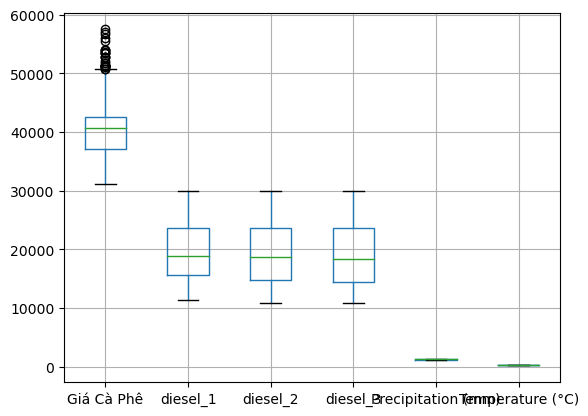

In [15]:
boxplot = data.boxplot()  # draw chart

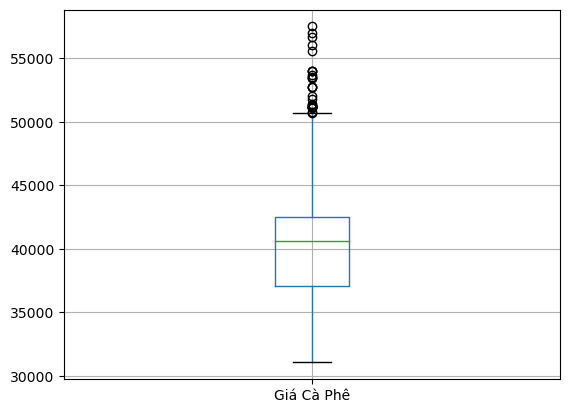

In [16]:
# further inspecting coffee outliers
boxplot = coffee_data.boxplot()  

In [17]:
# detecting outliers
outlier = np.where(coffee_data['Giá Cà Phê'] > 50000)

# removing outliers
data.drop(index=outlier[0], inplace=True)

C:\Users\Lamti\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<h1><center>-------------------------------------- Time Series Chart --------------------------------------</center></h1>

Text(0, 0.5, 'Values')

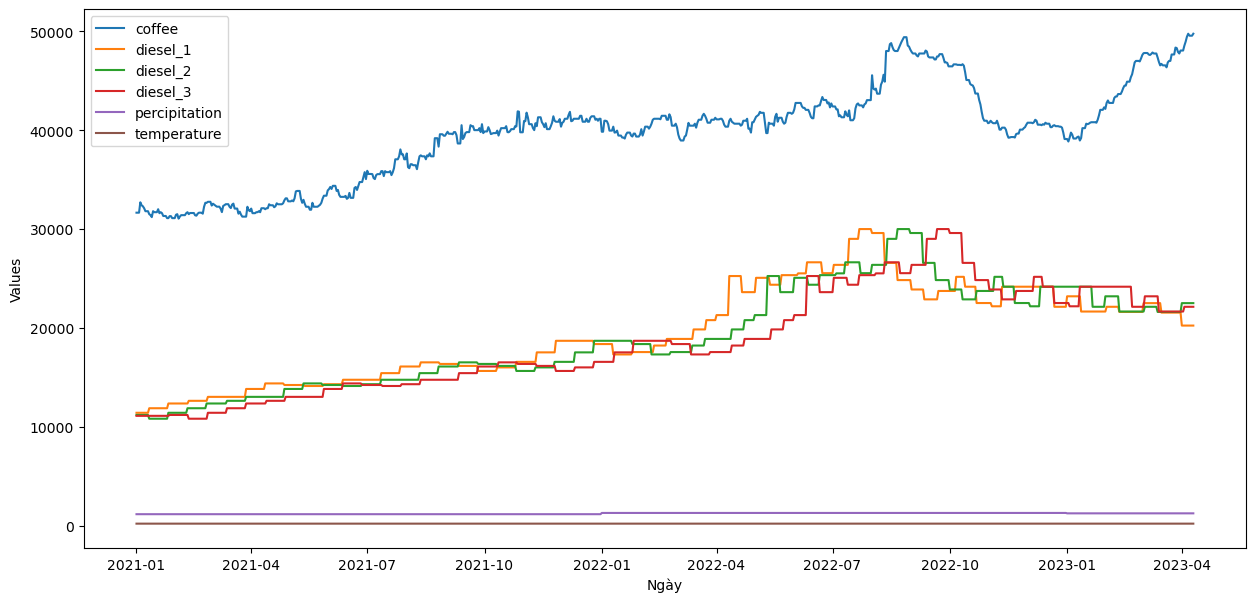

In [19]:
plt.figure(figsize=(15,7))

sns.lineplot(x="Ngày", y="Giá Cà Phê", data=data, label='coffee')
sns.lineplot(x="Ngày", y="diesel_1", data=data, label='diesel_1')
sns.lineplot(x="Ngày", y="diesel_2", data=data, label='diesel_2')
sns.lineplot(x="Ngày", y="diesel_3", data=data, label='diesel_3')
sns.lineplot(x="Ngày", y="Precipitation (mm)", data=data, label='percipitation')
sns.lineplot(x="Ngày", y="Temperature (°C)", data=data, label='temperature')

# set label
plt.ylabel("Values")

<h1><center>-------------------------------------- Correlation --------------------------------------</center></h1>

In [ ]:
# # Use heatmap to identify correlation between variables
f, ax = plt.subplots(figsize = (10, 5))
corr = data.corr()
ax = sns.heatmap(
    corr, vmin = -1, vmax = 1, center = 0, annot = True,
    cmap = sns.diverging_palette(20, 220, n = 200),
    square = False
)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, horizontalalignment = 'right');

<h1><center>-------------------------------------- Write to file --------------------------------------</center></h1>

In [ ]:
# Export the final dataset to excel
# data.to_excel('Dataset/data.xlsx', index=False)
%store data

# Normalization

In [ ]:
# set number of days
look_back = 60
%store look_back
predict_ahead = 30
%store predict_ahead

In [ ]:
# convert series to supervised learning

def series_to_supervised(data, n_in = look_back, n_out = predict_ahead, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# calculate metrics
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = sklearn.metrics.mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

def print_metrics(test, pre_test):
    
    testScore = np.sqrt(mean_squared_error(test,pre_test))
    print('RMSE: %.2f (đồng)' % (testScore))
    
    testScore = sklearn.metrics.mean_absolute_error(test, pre_test)
    print('\nMAE: %.2f (đồng)' % (testScore))
                            
    testScore = sklearn.metrics.mean_absolute_percentage_error(test, pre_test)
    print('\nMAPE: %.2f' % (testScore))
    
    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('\nMASE: %.2f' % (testScore))